Копируем Датасет с Kaggle

In [ ]:
# !kaggle datasets download -d puneet6060/intel-image-classification -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100%|████████████████████████████████████████| 346M/346M [00:38<00:00, 9.33MB/s]



Импортируем Библиотеки 

In [73]:
import torch 
import torch.nn as nn
import torchvision.models as models 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import mplcyberpunk
plt.style.use("cyberpunk")

Задаём функцию проверки и выбора устройства

In [52]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    else:
        return torch.device("cpu")

DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: mps


Преобразования и импорт модели

In [53]:
# Количество классов в датасете 
num_classes = 6

# Загружаем предобученную 
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Замораживаем все параметры
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой (классификатор) на новый с нужным числом классов
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.layer4.parameters():
    param.requires_grad = True
    
model = model.to(DEVICE)

print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'  {name}')

Trainable parameters:
  layer4.0.conv1.weight
  layer4.0.bn1.weight
  layer4.0.bn1.bias
  layer4.0.conv2.weight
  layer4.0.bn2.weight
  layer4.0.bn2.bias
  layer4.0.downsample.0.weight
  layer4.0.downsample.1.weight
  layer4.0.downsample.1.bias
  layer4.1.conv1.weight
  layer4.1.bn1.weight
  layer4.1.bn1.bias
  layer4.1.conv2.weight
  layer4.1.bn2.weight
  layer4.1.bn2.bias
  fc.weight
  fc.bias


Проверка Архитектуры модели

In [54]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Задаём параметры для обучения

In [56]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [57]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(
    root="../data/intel/seg_train/seg_train",
    transform=transform
)
test_dataset = datasets.ImageFolder(
    root="../data/intel/seg_test/seg_test",
    transform=transform
)

In [59]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f" Train samples: {len(train_dataset)} | Classes: {train_dataset.classes}")

 Train samples: 14034 | Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Функция для построения графика

In [60]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    all_losses = history['train_losses'] + history['valid_losses']
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(all_losses) + 0.1))
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()
    
    plt.show()

Обучение модели/ ДОобучение

Начинаем дообучение...
Epoch 1/5 | Train Loss: 0.2260, Acc: 0.9198 | Valid Loss: 0.2600, Acc: 0.9060
Epoch 2/5 | Train Loss: 0.2310, Acc: 0.9126 | Valid Loss: 0.2558, Acc: 0.9070
Epoch 3/5 | Train Loss: 0.2163, Acc: 0.9255 | Valid Loss: 0.2510, Acc: 0.9067
Epoch 4/5 | Train Loss: 0.2024, Acc: 0.9284 | Valid Loss: 0.2398, Acc: 0.9090
Epoch 5/5 | Train Loss: 0.2074, Acc: 0.9267 | Valid Loss: 0.2516, Acc: 0.9023
✅ Дообучение завершено


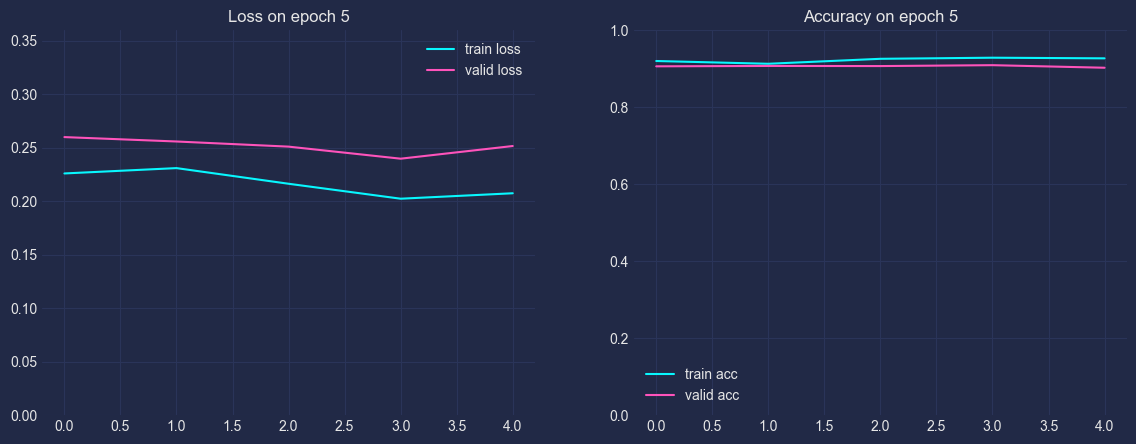

In [ ]:
history = {
    'train_losses': [],
    'valid_losses': [],
    'train_accs': [],
    'valid_accs': []
}

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

print("Начинаем дообучение...")
for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Оценка после эпохи
    train_loss, train_acc = evaluate_model(model, train_loader, criterion, DEVICE)
    valid_loss, valid_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Сохраняем
    history['train_losses'].append(train_loss)
    history['valid_losses'].append(valid_loss)
    history['train_accs'].append(train_acc)
    history['valid_accs'].append(valid_acc)
    
    print(f"Epoch {epoch+1}/5 | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Valid Loss: {valid_loss:.4f}, Acc: {valid_acc:.4f}")

print("✅ Дообучение завершено")

# --- ВЫВОД ФИНАЛЬНЫХ ГРАФИКОВ ---
plot_history(history)

Сохраняем модель

In [ ]:
# torch.save(model.state_dict(), "../models/intel_model.pt")
# print("Модель сохранена как ../models/intel_model.pt")

Модель сохранена как ../models/intel_model.pt


Проверка инференс мод с нуля

Тестируем изображение: 12150.jpg

✅ Предсказание: street
📊 Уверенность: 98.0%


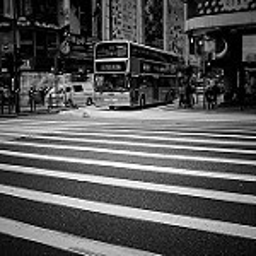

In [46]:
# --- Загрузка модели ---
model_inf = models.resnet18(weights=None)
model_inf.fc = nn.Linear(512, 6)
model_inf.load_state_dict(torch.load("../models/intel_model.pt", map_location=DEVICE))
model_inf = model_inf.to(DEVICE)
model_inf.eval()

# --- Трансформации ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Классы ---
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# --- Случайное изображение из seg_pred ---
pred_dir = "../data/intel/seg_pred/seg_pred"
pred_images = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))]

if not pred_images:
    print("⚠️ Папка seg_pred пуста.")
else:
    # 🔁 Случайный выбор
    random_image = random.choice(pred_images)
    test_image_path = os.path.join(pred_dir, random_image)
    print(f"Тестируем изображение: {random_image}")

    # --- Открываем и предсказываем ---
    image = Image.open(test_image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model_inf(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, idx = torch.max(probs, dim=1)
        predicted_class = CLASS_NAMES[idx.item()]

    print(f"\n✅ Предсказание: {predicted_class}")
    print(f"📊 Уверенность: {confidence.item() * 100:.1f}%")

    # Показать изображение
    display(image.resize((256, 256)))

Строим Confusion matrix

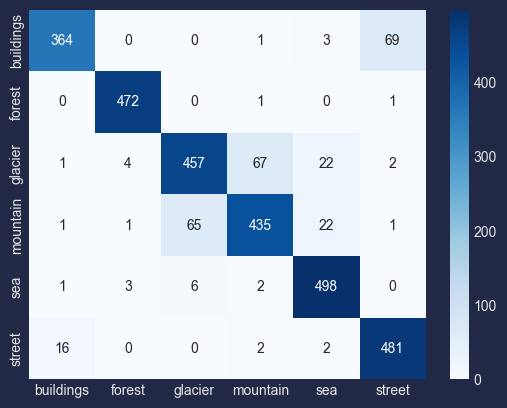

In [72]:
# Получаем предсказания на тесте
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Confusion Matrix Heatmap (3 строки) ---
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.show()

Выводим метрики

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Выводим все метрики
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

   buildings       0.95      0.83      0.89       437
      forest       0.98      1.00      0.99       474
     glacier       0.87      0.83      0.85       553
    mountain       0.86      0.83      0.84       525
         sea       0.91      0.98      0.94       510
      street       0.87      0.96      0.91       501

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

